<a href="https://colab.research.google.com/github/sangjun315/FedAvg-Pytorch/blob/main/OneshotFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("pip, setuptools, wheel 업그레이드 중...")
    # pip, setuptools, wheel을 먼저 업그레이드합니다.
    !pip install --quiet --upgrade pip setuptools wheel

    # --- (수정) ---
    # Colab 기본 pandas(2.2.2) 버전과 충돌하지 않도록
    # scikit-learn만 업그레이드합니다.
    print("필요한 라이브러리 (scikit-learn) 업그레이드 중...")
    !pip install --quiet --upgrade scikit-learn
    # --- (수정 끝) ---

    print("\n[알림] 설치/업그레이드 완료. '셀 2'부터 실행을 계속하세요.")

except ImportError:
    print("Google Colab 환경이 아닙니다. 드라이브 마운트를 건너뜁니다.")


Mounted at /content/drive
pip, setuptools, wheel 업그레이드 중...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
필요한 라이브러리 (scikit-learn) 업그레이드 중...

[알림] 설치/업그레이드 완료. '셀 2'부터 실행을 계속하세요.


In [ ]:
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 2) 라이브러리 임포트 ---")

import os
import pickle
import numpy as np
import scipy.io
import scipy.sparse # Sparse matrix
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm # 진행률 표시

# Sent140 데이터 다운로드용
import urllib.request
import zipfile

# Scikit-learn (논문의 SVM, AUC, 전처리용)
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

print("라이브러리 임포트 완료.")


--- (셀 2) 라이브러리 임포트 ---
라이브러리 임포트 완료.


In [4]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 3) 경로 및 파라미터 설정 ---")

# --- 기본 경로 ---
BASE_DRIVE_PATH = '/content/drive/My Drive/oneshot/'
DATA_PATH = BASE_DRIVE_PATH
RESULTS_PATH = os.path.join(BASE_DRIVE_PATH, 'results')

# --- Sent140 데이터 경로 ---
SENT140_ZIP_PATH = os.path.join(DATA_PATH, 'trainingandtestdata.zip')
SENT140_CSV_PATH = os.path.join(DATA_PATH, 'training.1600000.processed.noemoticon.csv')


# 결과 저장 폴더 생성
os.makedirs(RESULTS_PATH, exist_ok=True)
print(f"데이터 경로: {DATA_PATH}")
print(f"결과 저장 경로: {RESULTS_PATH}")

# 논문에서 주어진 파라미터
DATASET_PARAMS = {
    'emnist': {'cv': 10, 'data': 100, 'random': 50},
    'sent140': {'cv': 10, 'data': 10, 'random': 50},
    'gleam': {'cv': 10, 'data': 10, 'random': 10},
}
# 논문의 최소 샘플 수 (Section 4)
MIN_SAMPLES_THRESHOLD = {
    'emnist': 60,
    'sent140': 30,
    'gleam': 30
}

# Distillation(증류) 실험용 프록시 샘플 크기 (Figure 3)
PROXY_SAMPLE_SIZES = {
    'emnist': list(range(10, 1501, 50)),
    'sent140': list(range(10, 1501, 50)),
    'gleam': list(range(5, 201, 10))
}

print("경로 및 파라미터 설정 완료.")


--- (셀 3) 경로 및 파라미터 설정 ---
데이터 경로: /content/drive/My Drive/oneshot/
결과 저장 경로: /content/drive/My Drive/oneshot/results
경로 및 파라미터 설정 완료.


In [15]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 4) 데이터 로드 함수 정의 ---")

def load_emnist_data():
    """
    EMNIST .mat 파일 로드.
    논문의 'lowercase vs uppercase'를 모방하기 위해, 'A-M' (1-13) vs 'N-Z' (14-26)
    이진 분류 문제로 변환합니다.
    'writer' ID를 기준으로 클라이언트(장치) 데이터를 구성합니다.
    (스케일링은 데이터 로드 시점에 적용)
    """
    mat_path = os.path.join(DATA_PATH, 'emnist-letters.mat')
    print(f"EMNIST 데이터 로드 중: {mat_path}")
    try:
        mat = scipy.io.loadmat(mat_path)
        data = mat['dataset'][0][0]

        # Train
        train_images = data['train'][0][0]['images']
        train_labels = data['train'][0][0]['labels'].squeeze()
        train_writers = data['train'][0][0]['writers'].squeeze()
        # Test
        test_images = data['test'][0][0]['images']
        test_labels = data['test'][0][0]['labels'].squeeze()
        test_writers = data['test'][0][0]['writers'].squeeze()

        # 데이터 합치기
        all_images = np.concatenate((train_images, test_images))
        all_labels = np.concatenate((train_labels, test_labels))
        all_writers = np.concatenate((train_writers, test_writers))

        # 이미지 전처리 (Reshape 및 정규화 - 이것이 스케일링 역할)
        all_images_scaled = all_images.reshape(-1, 28 * 28) / 255.0

        # 이진 분류 문제로 변환 (A-M: 0, N-Z: 1)
        all_labels_binary = np.where(all_labels <= 13, 0, 1)

        print(f"총 이미지: {len(all_images_scaled)}, 총 레이블: {len(all_labels_binary)}, 총 writer: {len(np.unique(all_writers))}")

        client_data = {}
        unique_writers = np.unique(all_writers)

        for writer_id in unique_writers:
            indices = np.where(all_writers == writer_id)[0]
            if len(indices) == 0:
                continue
            writer_images = all_images_scaled[indices] # 이미 스케일링된 데이터 사용
            writer_labels = all_labels_binary[indices]

            # --- (수정) ---
            # GLEAM과의 포맷 통일: (X, y, scaler=None) - EMNIST는 이미 스케일됨
            client_data[str(writer_id)] = (writer_images, writer_labels, None)
            # --- (수정 끝) ---

        print(f"EMNIST: {len(client_data)}개의 클라이언트(writer) 데이터 생성 완료.")
        return client_data

    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {mat_path}")
        return None
    except Exception as e:
        print(f"EMNIST 데이터 로드 오류: {e}")
        return None

def load_sent140_data():
    """
    (TFF 대신 Pandas 사용)
    Sent140 CSV 파일을 다운로드하고 'Bag-of-Words' (Tfidf) 전처리.
    'user' ID를 기준으로 클라이언트별 (X, y) 데이터를 반환합니다.
    (TF-IDF 자체가 스케일링 역할을 하므로 별도 스케일러 없음)
    """
    print("Sent140 데이터 로드 중 (Pandas 사용)...")

    # 1. 파일 다운로드 및 압축 해제
    try:
        if not os.path.exists(SENT140_CSV_PATH):
            print(f"CSV 파일({os.path.basename(SENT140_CSV_PATH)}) 없음.")
            if not os.path.exists(SENT140_ZIP_PATH):
                print(f"오류: {SENT140_ZIP_PATH} 파일을 찾을 수 없습니다.")
                print(f"구글 드라이브 '{DATA_PATH}' 폴더에 'trainingandtestdata.zip' 파일을 직접 업로드해주세요.")
                return None

            print(f"압축 해제 중: {SENT140_ZIP_PATH}")
            with zipfile.ZipFile(SENT140_ZIP_PATH, 'r') as zip_ref:
                zip_ref.extract(os.path.basename(SENT140_CSV_PATH), path=DATA_PATH)
                print("압축 해제 완료.")

        # 2. Pandas로 CSV 로드
        print(f"CSV 로드 중: {SENT140_CSV_PATH}")
        col_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']
        df = pd.read_csv( SENT140_CSV_PATH, encoding='latin-1', header=None, names=col_names )

        # 3. TfidfVectorizer 학습 (전체 텍스트 대상)
        print("Sent140: TfidfVectorizer 학습 중 (모든 트윗 대상)...")
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        vectorizer.fit(df['text'].values)

        # 4. 클라이언트(user)별 데이터 생성
        print("Sent140: 클라이언트(user)별 데이터 변환 중...")
        client_data = {}
        grouped = df.groupby('user')

        for user_id, group_df in tqdm(grouped):
            X_client_text = group_df['text'].values
            y_client = np.where(group_df['sentiment'].values == 4, 1, 0)
            if len(y_client) == 0: continue
            X_client_tfidf = vectorizer.transform(X_client_text)

            # --- (수정) ---
            # GLEAM과의 포맷 통일: (X, y, scaler=None) - TF-IDF는 scaler 불필요
            client_data[user_id] = (X_client_tfidf, y_client, None)
            # --- (수정 끝) ---

        print(f"Sent140: {len(client_data)}개의 클라이언트 데이터 생성 완료.")
        return client_data

    except Exception as e:
        print(f"Sent140 데이터 로드 오류: {e}")
        return None

# --- (GLEAM 로더 대폭 수정 - 스케일링 로직 변경) ---

def _get_gleam_eat_intervals(annotate_df):
    """
    _annotate.c* 파일 DataFrame에서 'eat' 활동의 시작/끝 타임스탬프 쌍 반환.
    """
    intervals = []
    start_time = None
    if 'Activity' not in annotate_df.columns or 'Status' not in annotate_df.columns or 'Time' not in annotate_df.columns:
        raise ValueError(f"Annotate file missing required columns (Time, Activity, Status). Found columns: {list(annotate_df.columns)}")
    eat_events = annotate_df[annotate_df['Activity'].str.contains('eat', case=False, na=False)]
    for _, row in eat_events.iterrows():
        status = str(row['Status']).strip().replace('"', '')
        time = row['Time']
        if status == 'start': start_time = time
        elif status == 'stop' and start_time is not None:
            intervals.append((start_time, time))
            start_time = None
    return intervals

def _label_gleam_sensor_data(sensor_df, intervals):
    """타임스탬프 기준으로 레이블링 (1=eat, 0=other)"""
    def label_func(timestamp):
        for start, end in intervals:
            if start <= timestamp <= end: return 1
        return 0
    sensor_df['label'] = sensor_df['Unix Time'].apply(label_func)
    return sensor_df

def _create_gleam_features(accel_df):
    """슬라이딩 윈도우로 피처(X)와 레이블(y) 생성 (Mean, Std, Min, Max, Median, Var)"""
    WINDOW_SIZE = 50; STEP_SIZE = 25
    features = []; labels = []
    for i in range(0, len(accel_df) - WINDOW_SIZE + 1, STEP_SIZE):
        window = accel_df.iloc[i : i + WINDOW_SIZE]
        current_features = []
        for col in ['Value1', 'Value2', 'Value3']:
            current_features.extend([
                window[col].mean(), window[col].std(), window[col].min(),
                window[col].max(), window[col].median(), window[col].var()
            ])
        features.append(current_features)
        labels.append(window['label'].mode()[0])
    if not features: return None, None
    X_client = pd.DataFrame(features).fillna(0).values
    y_client = np.array(labels)
    return X_client, y_client

def load_gleam_data():
    """
    GLEAM 데이터 로드 (타임스탬프 매칭).
    (수정: 스케일링되지 않은 데이터와 학습된 scaler 반환)
    """
    gleam_path = os.path.join(DATA_PATH, 'GLEAM')
    print(f"GLEAM 데이터 로드 중 (New Logic, returns unscaled data + scaler): {gleam_path}")
    client_folders = [f.path for f in os.scandir(gleam_path) if f.is_dir() and f.name.isdigit()]
    client_data = {}
    print(f"GLEAM: {len(client_folders)}개의 클라이언트 폴더 처리 중...")

    for client_path in tqdm(client_folders, desc="Processing GLEAM clients"):
        client_id = os.path.basename(client_path)
        try:
            # --- 1. Annotate 파일 로드 및 처리 ---
            annotate_file = glob(os.path.join(client_path, f'{client_id}_annotate.*'))
            if not annotate_file: continue
            annotate_df = pd.read_csv(annotate_file[0], header=None, names=['Time', 'Activity', 'Status'], sep=',', encoding='latin-1', on_bad_lines='skip')
            annotate_df['Activity'] = annotate_df['Activity'].str.strip().str.replace('"', '')
            annotate_df['Status'] = annotate_df['Status'].str.strip().str.replace('"', '')
            annotate_df['Time'] = pd.to_numeric(annotate_df['Time'], errors='coerce')
            annotate_df = annotate_df.dropna(subset=['Time'])
            eat_intervals = _get_gleam_eat_intervals(annotate_df)
            if not eat_intervals: continue

            # --- 2. Sensor 파일 로드 및 처리 ---
            sensor_file = glob(os.path.join(client_path, f'{client_id}_sensor*'))
            # sensorDat 또는 sensorData.csv 찾기 (annotate 파일 제외)
            sensor_file = [f for f in sensor_file if 'annotate' not in f.lower()]
            if not sensor_file: continue
            sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip')
            sensor_df['Sensor'] = sensor_df['Sensor'].str.strip().str.replace('"', '')
            if 'Sensor' not in sensor_df.columns or 'Unix Time' not in sensor_df.columns: continue
            accel_df = sensor_df[sensor_df['Sensor'].str.contains('Accel', case=False, na=False)].copy()
            if accel_df.empty: continue
            for col in ['Value1', 'Value2', 'Value3', 'Unix Time']:
                accel_df[col] = pd.to_numeric(accel_df[col], errors='coerce')
            accel_df = accel_df.dropna().sort_values(by='Unix Time')

            # --- 3. 레이블링, 피처 생성 ---
            accel_df_labeled = _label_gleam_sensor_data(accel_df.reset_index(drop=True), eat_intervals)
            X_client_unscaled, y_client = _create_gleam_features(accel_df_labeled) # 스케일링 안 된 피처

            if X_client_unscaled is None or len(np.unique(y_client)) < 2: continue

            # --- 4. 로컬 스케일러 학습 ---
            scaler = StandardScaler()
            scaler.fit(X_client_unscaled) # 스케일러만 학습시키고 변환은 나중에 함

            # --- 5. (X_unscaled, y, scaler) 저장 ---
            client_data[client_id] = (X_client_unscaled, y_client, scaler)

        except Exception as e:
            # print(f"GLEAM Client {client_id} 처리 오류: {e}")
            # traceback.print_exc()
            continue

    print(f"GLEAM: {len(client_data)}개의 클라이언트 데이터 생성 완료.")
    return client_data

# --- (GLEAM 로더 수정 끝) ---

# 데이터 로더 맵
DATA_LOADERS = {
    'emnist': load_emnist_data,
    'sent140': load_sent140_data,
    'gleam': load_gleam_data,
}
print("데이터 로드 함수 정의 완료.")



--- (셀 4) 데이터 로드 함수 정의 ---
데이터 로드 함수 정의 완료.


In [16]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 5) 핵심 실험 함수 정의 ---")

# --- (수정) ---
# predict_ensemble 함수 수정: scaler 인자 제거 (모든 입력은 이미 스케일링된 것으로 가정)
def predict_ensemble(ensemble_models, X):
    """앙상블 모델의 예측 확률(proba)을 평균냅니다. (입력 X는 스케일링된 상태)"""
    if not ensemble_models:
        return np.full(X.shape[0], 0.5)

    all_preds = []
    # X는 이미 스케일링된 상태로 가정
    X_scaled = X

    for model in ensemble_models:
        try:
            all_preds.append(model.predict_proba(X_scaled)[:, 1])
        except Exception as e:
            # print(f"앙상블 예측 오류: {e}")
            all_preds.append(np.full(X_scaled.shape[0], 0.5))

    return np.mean(all_preds, axis=0)
# --- (수정 끝) ---

# --- (수정) ---
# evaluate_model 함수 수정: scaler 인자 제거 (모든 입력은 이미 스케일링된 것으로 가정)
def evaluate_model(model_or_ensemble, device_test_sets):
    """
    주어진 모델(단일 SVM 또는 앙상블 리스트)을
    모든 디바이스의 테스트셋에서 평가하고 평균 AUC를 반환합니다.
    (입력 device_test_sets의 X_test는 스케일링된 상태)
    """
    all_device_aucs = []
    is_ensemble = isinstance(model_or_ensemble, list)

    for client_id, (X_test, y_test) in device_test_sets.items(): # X_test는 스케일링된 상태
        if len(np.unique(y_test)) < 2:
            continue

        try:
            # X_test는 이미 스케일링된 상태이므로 추가 변환 불필요
            X_test_scaled = X_test

            if is_ensemble:
                y_pred_proba = predict_ensemble(model_or_ensemble, X_test_scaled) # 스케일된 X 전달
            else: # 단일 모델 (Ideal, Local)
                y_pred_proba = model_or_ensemble.predict_proba(X_test_scaled)[:, 1] # 스케일된 X 사용

            auc = roc_auc_score(y_test, y_pred_proba)
            all_device_aucs.append(auc)
        except Exception as e:
            # print(f"평가 오류 (Client {client_id}): {e}")
            all_device_aucs.append(0.5)

    return np.mean(all_device_aucs) if all_device_aucs else 0.5
# --- (수정 끝) ---


def run_experiment(dataset_name, client_data):
    """
    논문의 전체 실험 파이프라인을 실행합니다.
    1. 로컬 모델 학습 (Train/Test/Val 스플릿, 최소 샘플 필터링)
    2. 'Ideal' 모델 학습 (수정: 전역 스케일링 제거, 로컬 스케일된 데이터 집계 사용)
    3. 앙상블 선택 (CV, Data, Random)
    4. 모든 모델 평가 (on all client test sets)
    5. 증류 (Distillation) 수행 (수정: 전역 스케일링 제거)
    """
    print(f"--- [{dataset_name}] 실험 시작 ---")

    if client_data is None:
        print(f"[{dataset_name}] 데이터가 없어 실험을 건너뜁니다.")
        return None

    PARAMS = DATASET_PARAMS[dataset_name]
    MIN_SAMPLES = MIN_SAMPLES_THRESHOLD[dataset_name]

    device_models = {}      # 학습된 로컬 SVM 모델
    device_scores = {}      # 로컬 validation AUC 점수 (CV 선택용)
    device_test_sets = {}   # (X_test, y_test) - 로컬 스케일링된 데이터
    device_local_baseline_scores = {} # 로컬 모델의 로컬 테스트 AUC (Local 베이스라인용)

    all_X_train_local_scaled, all_y_train = [], [] # 로컬 스케일링된 데이터 (Ideal 모델 학습용)
    all_X_val_local_scaled, all_y_val = [], []     # 로컬 스케일링된 데이터 (Distillation용)

    print(f"[{dataset_name}] 1/5: 로컬 모델 학습 중...")

    # 1. 모든 적격한(eligible) 장치에서 로컬 모델 학습
    for client_id, (X, y) in tqdm(client_data.items()): # X는 셀 4에서 이미 로컬 스케일링된 상태

        # 데이터가 2개 클래스를 모두 가졌는지, 최소 샘플 수를 넘겼는지 확인
        unique_labels = np.unique(y)
        if len(y) < MIN_SAMPLES or len(unique_labels) < 2:
            continue

        # 논문 스플릿: 50% train, 40% test, 10% validation
        try:
            # stratify=y는 클래스 비율을 유지하며 분할
            X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
            # 남은 50%를 40% (test)와 10% (val)로 분할 (비율 4:1 -> test_size=0.2)
            X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42, stratify=y_rem)
        except ValueError:
            # Stratify 실패 (매우 적은 샘플)
            continue

        # 1-1. 로컬 모델 학습 (RBF 커널 SVM)
        # (X_train은 이미 로컬 스케일링된 상태)
        model = SVC(kernel='rbf', probability=True, C=1.0, class_weight='balanced', random_state=42)
        try:
            model.fit(X_train, y_train)
        except Exception as e:
            # print(f"학습 오류 (Client {client_id}): {e}")
            continue # 학습 실패 시 이 클라이언트 건너뜀

        # 1-2. 로컬 Validation 점수 (CV 앙상블 선택용)
        # (X_val도 이미 로컬 스케일링된 상태)
        if len(np.unique(y_val)) < 2:
            val_auc = 0.5 # 검증셋에 클래스 1개면 0.5점
        else:
            val_preds_proba = model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, val_preds_proba)

        # 1-3. 로컬 Test 점수 (Local 베이스라인용)
        # (X_test도 이미 로컬 스케일링된 상태)
        if len(np.unique(y_test)) < 2:
            test_auc = 0.5
        else:
            test_preds_proba = model.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, test_preds_proba)

        # 1-4. 결과 저장
        device_models[client_id] = model
        device_scores[client_id] = val_auc
        device_test_sets[client_id] = (X_test, y_test) # 로컬 스케일링된 테스트셋 저장
        device_local_baseline_scores[client_id] = test_auc

        # 'Ideal' 모델 및 'Distillation'용 데이터 수집 (로컬 스케일링된 데이터)
        all_X_train_local_scaled.append(X_train)
        all_y_train.append(y_train)
        all_X_val_local_scaled.append(X_val)
        all_y_val.append(y_val)

    if not device_models:
        print(f"[{dataset_name}] 학습할 수 있는 클라이언트가 없습니다. (샘플 수 부족)")
        return None

    print(f"[{dataset_name}] 2/5: 'Unachievable Ideal' 모델 학습 중...")

    # --- (수정) ---
    # 2. 'Ideal' 모델 학습 (전역 스케일링 제거, 로컬 스케일된 데이터 집계 사용)

    # 2-1. 로컬 스케일링된 학습 데이터 집계
    if isinstance(all_X_train_local_scaled[0], scipy.sparse.csr_matrix):
        # Sparse Matrix 집계
        X_ideal_local_scaled = scipy.sparse.vstack(all_X_train_local_scaled)
    else:
        # Dense Matrix 집계
        X_ideal_local_scaled = np.vstack(all_X_train_local_scaled)

    y_ideal = np.concatenate(all_y_train)

    # 2-2. 전역 스케일링 단계 제거

    # 2-3. Ideal 모델 학습 (로컬 스케일된 데이터 사용)
    ideal_model = SVC(kernel='rbf', probability=True, C=1.0, class_weight='balanced', random_state=42)
    ideal_model.fit(X_ideal_local_scaled, y_ideal)

    # 2-4. 'Ideal' 모델 평가 (수정: scaler=None 전달, device_test_sets 사용)
    ideal_auc = evaluate_model(ideal_model, device_test_sets) # device_test_sets는 로컬 스케일됨
    # --- (수정 끝) ---

    print(f"[{dataset_name}] 3/5: 앙상블 선택 및 평가 중...")

    # 3. 앙상블 선택
    eligible_clients = list(device_models.keys())
    eligible_scores = device_scores # Val AUCs
    eligible_models = device_models

    # --- (수정) ---
    # scaler=None 제거 (evaluate_model 함수 시그니처 변경)
    # 3-1. Full Ensemble
    full_ensemble_models = list(eligible_models.values())
    full_ensemble_auc = evaluate_model(full_ensemble_models, device_test_sets)

    # 3-2. CV Selection (k)
    sorted_clients_cv = sorted(eligible_scores, key=eligible_scores.get, reverse=True)
    cv_clients = sorted_clients_cv[:PARAMS['cv']]
    cv_ensemble_models = [eligible_models[c] for c in cv_clients]
    cv_auc = evaluate_model(cv_ensemble_models, device_test_sets)

    # 3-3. Data Selection (k)
    # client_data는 load_gleam_data 결과 (스케일링된 데이터)
    client_sizes = {cid: client_data[cid][1].shape[0] for cid in eligible_clients}
    sorted_clients_data = sorted(client_sizes, key=client_sizes.get, reverse=True)
    data_clients = sorted_clients_data[:PARAMS['data']]
    data_ensemble_models = [eligible_models[c] for c in data_clients]
    data_auc = evaluate_model(data_ensemble_models, device_test_sets)

    # 3-4. Random Selection (k) - 5회 평균
    random_aucs = []
    for _ in range(5):
        if len(eligible_clients) < PARAMS['random']:
            random_clients = eligible_clients
        else:
            random_clients = np.random.choice(eligible_clients, PARAMS['random'], replace=False)

        random_ensemble_models = [eligible_models[c] for c in random_clients]
        random_aucs.append(evaluate_model(random_ensemble_models, device_test_sets))
    random_auc = np.mean(random_aucs)
    # --- (수정 끝) ---

    # 4. 베이스라인 평가
    # 4-1. Local Baseline (평균)
    local_auc = np.mean(list(device_local_baseline_scores.values()))

    # Figure 1용 결과 집계
    fig1_results = {
        'Unachievable Ideal': ideal_auc,
        'Local': local_auc,
        'Full Ensemble': full_ensemble_auc,
        f'CV, k={PARAMS["cv"]}': cv_auc,
        f'Data, k={PARAMS["data"]}': data_auc,
        f'Random, k={PARAMS["random"]}': random_auc
    }

    # --- (Figure 2 로직 수정 없음) ---
    # Figure 2용 결과 (모든 데이터셋에 대해 생성)
    if dataset_name == 'emnist':
        fig2_ensemble = cv_ensemble_models
        fig2_ensemble_name = f'CV, k={PARAMS["cv"]}'
    elif dataset_name == 'sent140':
        data_k10_clients = sorted_clients_data[:DATASET_PARAMS['sent140']['data']] # k=10
        fig2_ensemble = [eligible_models[c] for c in data_k10_clients]
        fig2_ensemble_name = f'Data, k={DATASET_PARAMS["sent140"]["data"]}' # k=10
    else: # gleam
        fig2_ensemble = full_ensemble_models
        fig2_ensemble_name = 'Full Ensemble'

    ensemble_scores = []
    for client_id, (X_test, y_test) in device_test_sets.items(): # X_test는 로컬 스케일됨
        if len(np.unique(y_test)) < 2: continue
        try:
            pred_proba = predict_ensemble(fig2_ensemble, X_test) # 스케일된 X 전달
            ensemble_scores.append(roc_auc_score(y_test, pred_proba))
        except:
            ensemble_scores.append(0.5)

    fig2_results = {
        'local_scores': list(device_local_baseline_scores.values()),
        'ensemble_scores': ensemble_scores,
        'ensemble_name': fig2_ensemble_name # 플롯 라벨용
    }
    # --- (수정 끝) ---

    print(f"[{dataset_name}] 4/5: 증류(Distillation) 모델 학습 중...")

    # 5. Distillation (증류)

    # 5-1. 프록시 데이터 준비 (로컬 스케일링된 Validation Set 집계)
    if not all_X_val_local_scaled: # 변수명 변경
        print(f"[{dataset_name}] 증류용 프록시 데이터가 없습니다. 증류 단계를 건너뜁니다.")
        fig3_results = { 'proxy_sizes': [], 'distilled_aucs': [], 'teacher_auc': 0, 'teacher_name': 'N/A' }
    else:
        # --- (수정) ---
        # 전역 스케일링 제거
        if isinstance(all_X_val_local_scaled[0], scipy.sparse.csr_matrix):
            X_proxy_local_scaled = scipy.sparse.vstack(all_X_val_local_scaled)
        else:
            X_proxy_local_scaled = np.vstack(all_X_val_local_scaled)

        y_proxy = np.concatenate(all_y_val)

        # 5-2. Teacher 모델 설정 (fig2_results와 동일)
        teacher_ensemble = fig2_ensemble
        teacher_name = fig2_ensemble_name
        # Teacher AUC 계산 시 scaler=None 전달 (evaluate_model 수정됨)
        teacher_auc = evaluate_model(teacher_ensemble, device_test_sets)
        # --- (수정 끝) ---

        # 5-3. 프록시 데이터에 "Soft Label" 생성 (Teacher의 예측 확률)
        print(f"[{dataset_name}] Teacher 모델({teacher_name})로 프록시 데이터에 soft-label 생성 중...")
        # predict_ensemble은 로컬 스케일된 X_proxy 사용 (scaler 인수 제거됨)
        y_soft_labels = predict_ensemble(teacher_ensemble, X_proxy_local_scaled)

        # 5-3-1. Distillation용 프록시 데이터 전역 스케일링 제거

        # 5-4. 프록시 샘플 크기별로 Student 모델(SVR) 학습
        distilled_aucs = []
        proxy_sample_sizes = PROXY_SAMPLE_SIZES[dataset_name]

        proxy_sample_sizes = [s for s in proxy_sample_sizes if s <= len(y_soft_labels)]
        if not proxy_sample_sizes or (len(y_soft_labels) > 0 and proxy_sample_sizes[-1] < len(y_soft_labels)):
             if len(y_soft_labels) > 0: proxy_sample_sizes.append(len(y_soft_labels))


        for k in tqdm(proxy_sample_sizes, desc="Distilling"):
            indices = np.random.choice(len(y_soft_labels), k, replace=False)
            # --- (수정) ---
            # 로컬 스케일링된 프록시 데이터 사용
            X_proxy_sample = X_proxy_local_scaled[indices]
            # --- (수정 끝) ---
            y_soft_sample = y_soft_labels[indices]

            student_model_svr = SVR(kernel='rbf', C=1.0)
            student_model_svr.fit(X_proxy_sample, y_soft_sample)

            # 5-5. Student 모델 평가 (모든 디바이스 테스트셋)
            student_device_aucs = []
            for client_id, (X_test, y_test) in device_test_sets.items(): # X_test는 로컬 스케일링 상태
                if len(np.unique(y_test)) < 2: continue
                try:
                    # --- (수정) ---
                    # Student 평가 시에도 로컬 스케일링된 X_test 사용 (전역 스케일러 적용 제거)
                    X_test_for_student = X_test
                    # --- (수정 끝) ---

                    y_pred_distilled = student_model_svr.predict(X_test_for_student)
                    y_pred_distilled = np.clip(y_pred_distilled, 0, 1)
                    student_device_aucs.append(roc_auc_score(y_test, y_pred_distilled))
                except:
                    student_device_aucs.append(0.5)

            distilled_aucs.append(np.mean(student_device_aucs))

        # Figure 3용 결과
        fig3_results = {
            'proxy_sizes': proxy_sample_sizes,
            'distilled_aucs': distilled_aucs,
            'teacher_auc': teacher_auc,
            'teacher_name': teacher_name
        }

    print(f"--- [{dataset_name}] 실험 완료 ---")

    # 모든 결과 반환
    return {
        'fig1': fig1_results,
        'fig2': fig2_results,
        'fig3': fig3_results
    }

print("핵심 실험 함수 정의 완료.")

--- (셀 5) 핵심 실험 함수 정의 ---
핵심 실험 함수 정의 완료.


In [ ]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 6) EMNIST 실험 실행 ---")

try:
    # 1. EMNIST 데이터 로드
    emnist_client_data = DATA_LOADERS['emnist']()

    # 2. EMNIST 실험 실행
    emnist_results = run_experiment('emnist', emnist_client_data)

    # 3. 결과 저장
    if emnist_results:
        save_path = os.path.join(RESULTS_PATH, 'emnist_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(emnist_results, f)
        print(f"\nEMNIST 결과 저장 완료: {save_path}")
    else:
        print("\nEMNIST 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nEMNIST 실험 중 심각한 오류 발생: {e}")

--- (셀 6) EMNIST 실험 실행 ---
EMNIST 데이터 로드 중: /content/drive/My Drive/oneshot/emnist-letters.mat
총 이미지: 145600, 총 레이블: 145600, 총 writer: 3585
EMNIST: 3585개의 클라이언트(writer) 데이터 생성 완료.
--- [emnist] 실험 시작 ---
[emnist] 1/5: 로컬 모델 학습 중...


100%|██████████| 3585/3585 [00:07<00:00, 498.05it/s]


[emnist] 2/5: 'Unachievable Ideal' 모델 학습 중...
[emnist] 3/5: 앙상블 선택 및 평가 중...
[emnist] 4/5: 증류(Distillation) 모델 학습 중...
[emnist] Teacher 모델(CV, k=10)로 프록시 데이터에 soft-label 생성 중...


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


--- [emnist] 실험 완료 ---

EMNIST 결과 저장 완료: /content/drive/My Drive/oneshot/results/emnist_results.pkl


In [30]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 7) Sent140 실험 실행 ---")

try:
    # 1. Sent140 데이터 로드
    sent140_client_data = DATA_LOADERS['sent140']()

    # 2. Sent140 실험 실행
    sent140_results = run_experiment('sent140', sent140_client_data)

    # 3. 결과 저장
    if sent140_results:
        save_path = os.path.join(RESULTS_PATH, 'sent140_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(sent140_results, f)
        print(f"\nSent140 결과 저장 완료: {save_path}")
    else:
        print("\nSent140 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nSent140 실험 중 심각한 오류 발생: {e}")
    import traceback
    traceback.print_exc()


--- (셀 7) Sent140 실험 실행 ---
Sent140 데이터 로드 중 (Pandas 사용)...
CSV 파일(training.1600000.processed.noemoticon.csv) 없음.
압축 해제 중: /content/drive/My Drive/oneshot/trainingandtestdata.zip
압축 해제 완료.
CSV 로드 중: /content/drive/My Drive/oneshot/training.1600000.processed.noemoticon.csv
Sent140: TfidfVectorizer 학습 중 (모든 트윗 대상)...
Sent140: 클라이언트(user)별 데이터 변환 중...


100%|██████████| 659775/659775 [04:16<00:00, 2573.04it/s]


Sent140: 659775개의 클라이언트 데이터 생성 완료.
--- [sent140] 실험 시작 ---
[sent140] 1/5: 로컬 모델 학습 중...


100%|██████████| 659775/659775 [00:18<00:00, 36437.37it/s]


[sent140] 2/5: 'Unachievable Ideal' 모델 학습 중...
[sent140] 3/5: 앙상블 선택 및 평가 중...
[sent140] 4/5: 증류(Distillation) 모델 학습 중...
[sent140] Teacher 모델(Data, k=10)로 프록시 데이터에 soft-label 생성 중...


Distilling: 100%|██████████| 31/31 [01:25<00:00,  2.77s/it]

--- [sent140] 실험 완료 ---

Sent140 결과 저장 완료: /content/drive/My Drive/oneshot/results/sent140_results.pkl


In [17]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 8) GLEAM 실험 실행 ---")

try:
    # 1. GLEAM 데이터 로드
    gleam_client_data = DATA_LOADERS['gleam']()

    # 2. GLEAM 실험 실행
    gleam_results = run_experiment('gleam', gleam_client_data)

    # 3. 결과 저장
    if gleam_results:
        save_path = os.path.join(RESULTS_PATH, 'gleam_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(gleam_results, f)
        print(f"\nGLEAM 결과 저장 완료: {save_path}")
    else:
        print("\nGLEAM 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nGLEAM 실험 중 심각한 오류 발생: {e}")
    import traceback
    traceback.print_exc()


--- (셀 8) GLEAM 실험 실행 ---
GLEAM 데이터 로드 중 (New Logic, returns unscaled data + scaler): /content/drive/My Drive/oneshot/GLEAM
GLEAM: 38개의 클라이언트 폴더 처리 중...


Processing GLEAM clients:   5%|▌         | 2/38 [00:02<00:40,  1.13s/it]/tmp/ipython-input-2146167008.py:199: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip')
Processing GLEAM clients:  26%|██▋       | 10/38 [00:11<00:31,  1.13s/it]/tmp/ipython-input-2146167008.py:199: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip')
Processing GLEAM clients:  29%|██▉       | 11/38 [00:13<00:36,  1.35s/it]/tmp/ipython-input-2146167008.py:199: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_df = pd.r

GLEAM: 38개의 클라이언트 데이터 생성 완료.
--- [gleam] 실험 시작 ---
[gleam] 1/5: 로컬 모델 학습 중...


  0%|          | 0/38 [00:00<?, ?it/s]


GLEAM 실험 중 심각한 오류 발생: too many values to unpack (expected 2)



Traceback (most recent call last):
  File "/tmp/ipython-input-4159859377.py", line 9, in <cell line: 0>
    gleam_results = run_experiment('gleam', gleam_client_data)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3890627213.py", line 88, in run_experiment
    for client_id, (X, y) in tqdm(client_data.items()): # X는 셀 4에서 이미 로컬 스케일링된 상태
                   ^^^^^^
ValueError: too many values to unpack (expected 2)


In [18]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 9) Figure 생성 함수 정의 ---")

# Matplotlib 스타일 설정
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('dark_background') # Fallback

def load_result(dataset_name):
    """결과 pkl 파일을 안전하게 로드합니다."""
    load_path = os.path.join(RESULTS_PATH, f'{dataset_name}_results.pkl')
    if not os.path.exists(load_path):
        print(f"경고: {load_path} 에서 결과 파일을 찾을 수 없습니다. (해당 실험 셀을 먼저 실행하세요)")
        return None
    try:
        with open(load_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"결과 파일 로드 오류 ({load_path}): {e}")
        return None

def plot_figure_1(emnist_res, sent140_res, gleam_res):
    """Figure 1: 3개 데이터셋의 평균 AUC 비교 막대 그래프"""

    datasets = {
        'EMNIST': emnist_res['fig1'] if emnist_res else None,
        'Sentiment140': sent140_res['fig1'] if sent140_res else None,
        'Gleam': gleam_res['fig1'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 1: Mean AUC across devices', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        labels = list(data.keys())
        values = list(data.values())

        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(labels)))
        bars = ax.bar(labels, values, color=colors)
        ax.set_title(name)
        ax.set_ylabel('Mean AUC Score')
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # y축 범위 설정 (논문과 유사하게)
        if name == 'EMNIST':
            ax.set_ylim(0.5, 1.0)
        elif name == 'Sentiment140':
            ax.set_ylim(0.2, 0.8)
        elif name == 'Gleam':
            ax.set_ylim(0.5, 1.0)

        # 막대 위에 값 표시
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# --- (수정) ---
def plot_figure_2(emnist_res, sent140_res, gleam_res):
    """Figure 2: (수정) 3개 데이터셋의 디바이스 점수 분포 (백분위수)"""

    datasets = {
        'EMNIST': emnist_res['fig2'] if emnist_res else None,
        'Sentiment140': sent140_res['fig2'] if sent140_res else None,
        'Gleam': gleam_res['fig2'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 2: Device score distribution (Percentile by score)', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        local_scores = sorted(data['local_scores'])
        ensemble_scores = sorted(data['ensemble_scores'])
        ensemble_name = data.get('ensemble_name', 'Ensemble') # .get()으로 하위 호환성

        if not local_scores or not ensemble_scores:
            ax.set_title(f"{name}\n(Empty data)")
            ax.text(0.5, 0.5, 'Result lists are empty', ha='center', va='center', transform=ax.transAxes)
            continue

        # 백분위수 (x축)
        percentiles_local = np.linspace(0, 100, len(local_scores))
        percentiles_ensemble = np.linspace(0, 100, len(ensemble_scores))

        ax.plot(percentiles_local, local_scores, label='Local Scores', lw=2)
        ax.plot(percentiles_ensemble, ensemble_scores, label=f'{ensemble_name} Ensemble', lw=2)

        ax.set_title(name)
        ax.set_xlabel('Percentile (by score)')
        ax.set_ylabel('AUC Score')



        ax.set_ylim(0.0, 1.05) # 기본 범위

        ax.set_xlim(0, 100)
        ax.legend()

    plt.tight_layout()
    plt.show()
# --- (수정 끝) ---

def plot_figure_3(emnist_res, sent140_res, gleam_res):
    """Figure 3: 증류(Distillation) 모델 성능 비교"""

    datasets = {
        'EMNIST': emnist_res['fig3'] if emnist_res else None,
        'Sentiment140': sent140_res['fig3'] if sent140_res else None,
        'Gleam': gleam_res['fig3'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 3: Comparison of distilled model and ensemble', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        proxy_sizes = data['proxy_sizes']
        distilled_aucs = data['distilled_aucs']
        teacher_auc = data['teacher_auc']
        teacher_name = data['teacher_name']

        if not proxy_sizes or not distilled_aucs:
            ax.set_title(f"{name}\n(Empty data)")
            ax.text(0.5, 0.5, 'Distillation results are empty', ha='center', va='center', transform=ax.transAxes)
            continue

        # Teacher 앙상블 (수평선)
        ax.axhline(y=teacher_auc, color='C0', linestyle='-', lw=3, label=f'{teacher_name} Ensemble (AUC: {teacher_auc:.3f})')

        # Distilled 모델 (라인 그래프)
        # (논문처럼 오차 막대(error bar)를 표시하려면 5회 반복 평균 필요. 여기서는 단일 실행)
        ax.plot(proxy_sizes, distilled_aucs, marker='o', linestyle='--', color='C1', label='Distilled Model')

        ax.set_title(name)
        ax.set_xlabel('Number of Proxy Samples')
        ax.set_ylabel('Mean AUC Score')
        ax.legend()

        # y축 범위 설정 (논문과 유사하게)
        if name == 'EMNIST':
            ax.set_ylim(0.60, 0.75)
        elif name == 'Sentiment140':
            ax.set_ylim(0.5, 0.75)
        elif name == 'Gleam':
            ax.set_ylim(0.5, 0.75)

    plt.tight_layout()
    plt.show()

print("Figure 생성 함수 정의 완료.")


--- (셀 9) Figure 생성 함수 정의 ---
Figure 생성 함수 정의 완료.


/tmp/ipython-input-1681801353.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipython-input-1681801353.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipython-input-1681801353.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


--- (셀 10) 모든 Figure 생성 ---
저장된 결과(.pkl) 로드 중...

--- Figure 1 (Mean AUC) ---


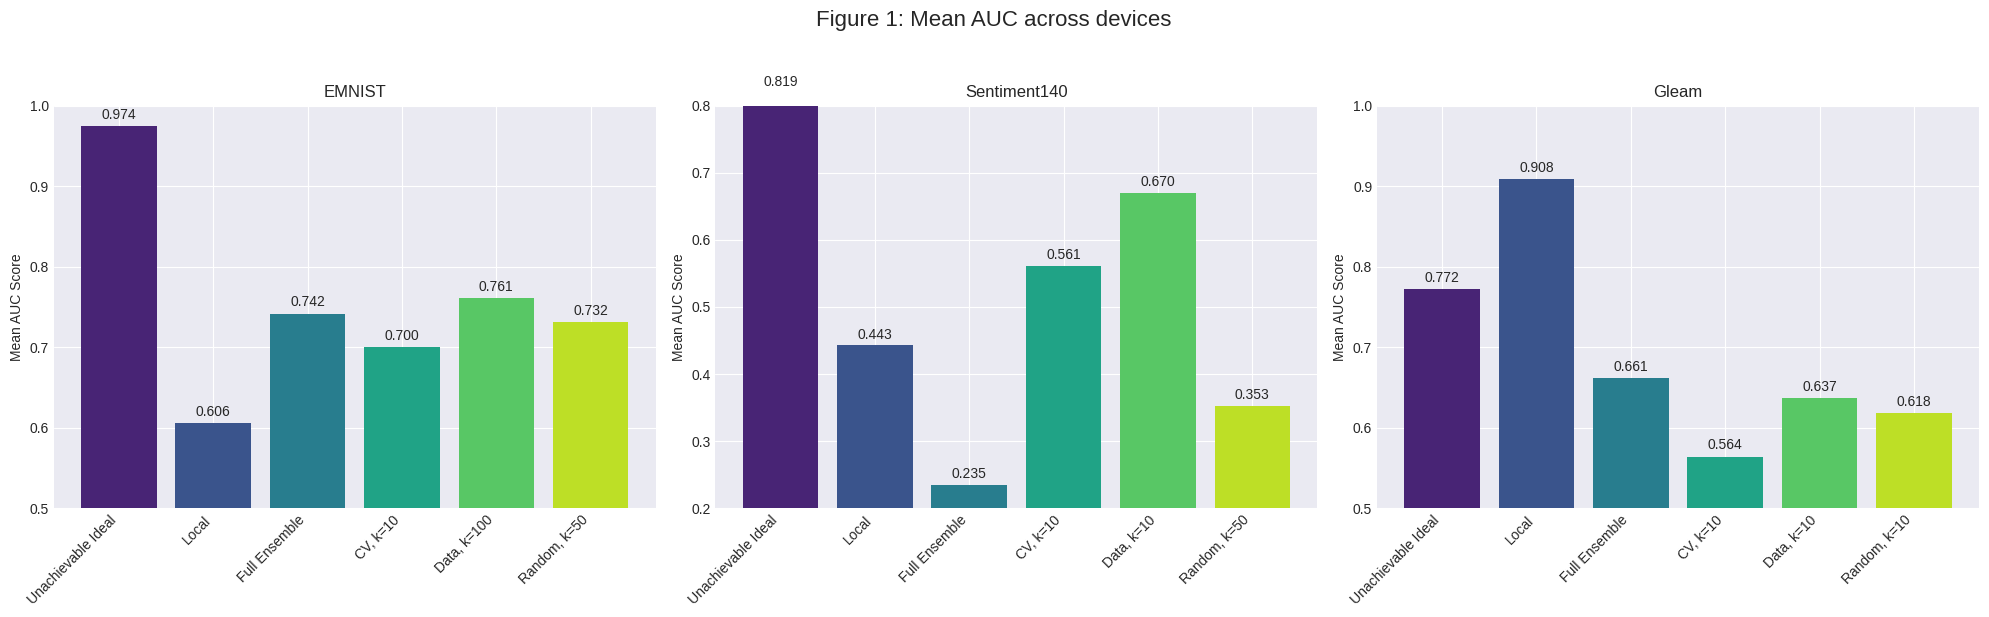


--- Figure 2 (Device Distribution) ---


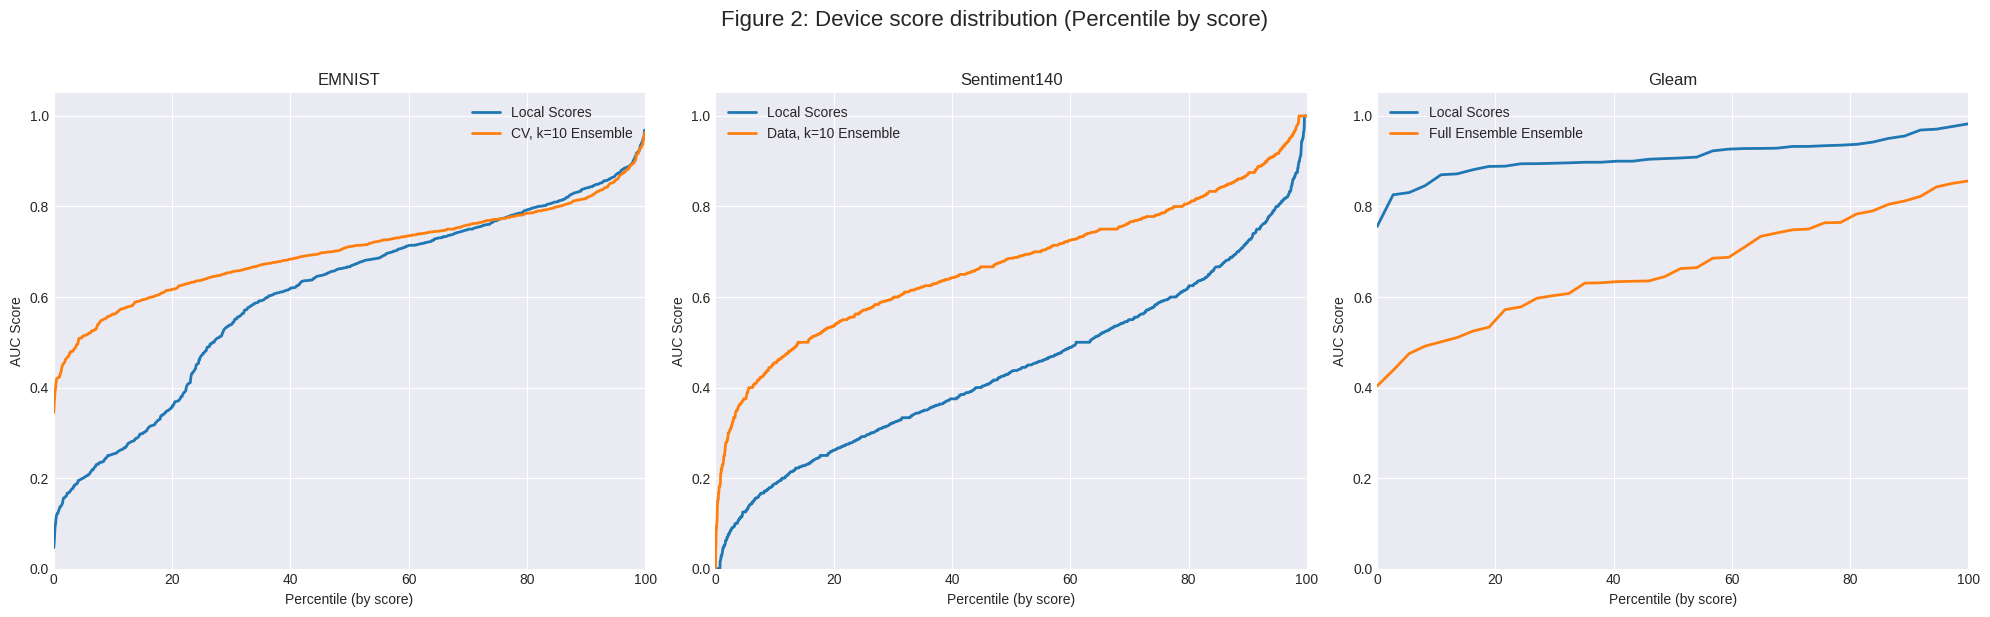


--- Figure 3 (Distillation) ---


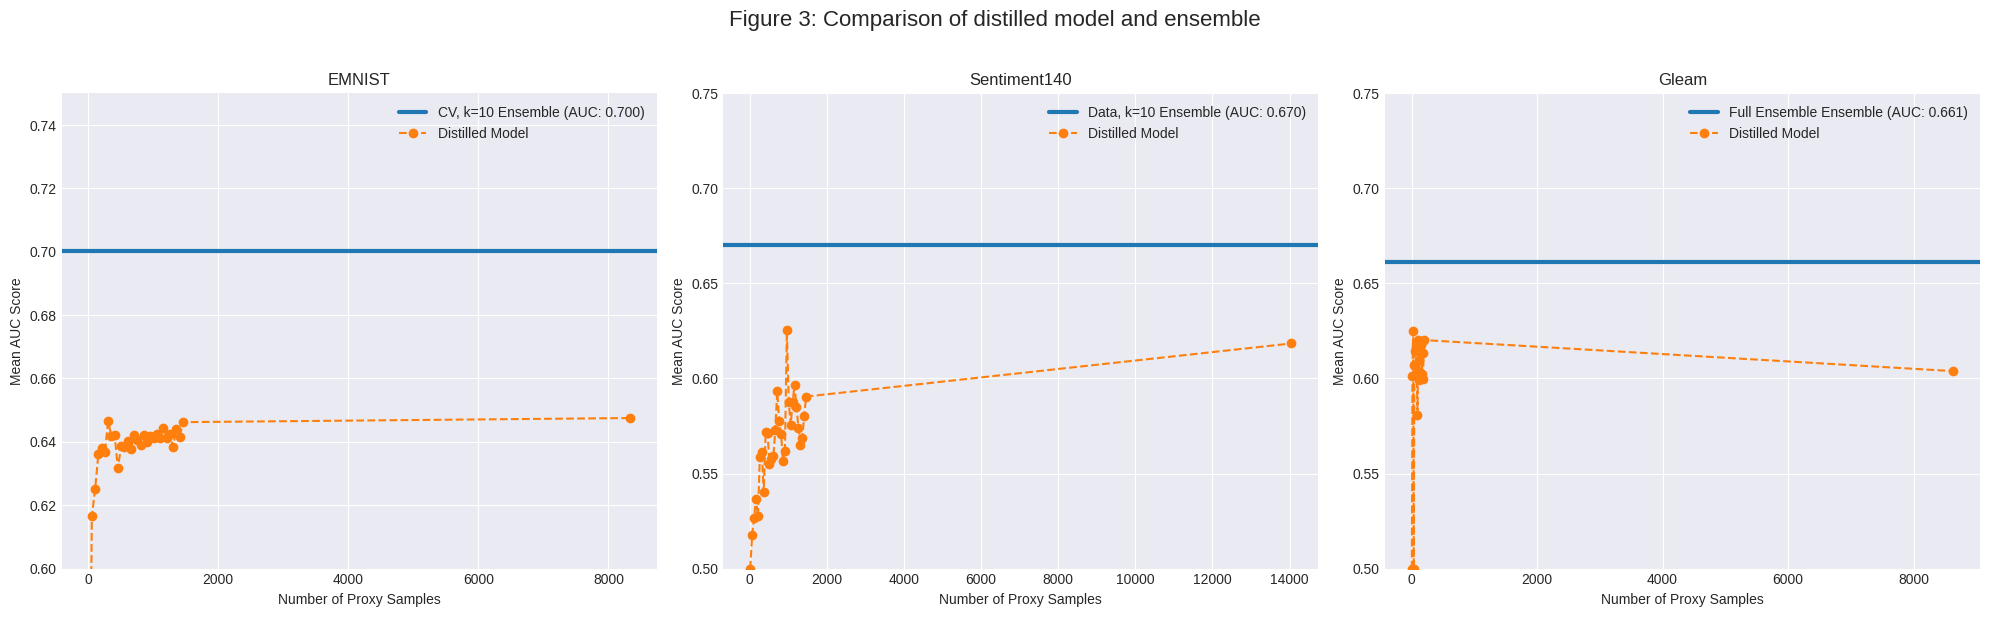


--- Figure 생성 완료 ---


In [19]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 10) 모든 Figure 생성 ---")

# 1. 모든 결과 파일 로드
print("저장된 결과(.pkl) 로드 중...")
emnist_results_loaded = load_result('emnist')
sent140_results_loaded = load_result('sent140')
gleam_results_loaded = load_result('gleam')

# 2. Figure 1 출력
print("\n--- Figure 1 (Mean AUC) ---")
plot_figure_1(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded)

# 3. Figure 2 출력
print("\n--- Figure 2 (Device Distribution) ---") # (수정)
plot_figure_2(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded) # (수정)

# 4. Figure 3 출력
print("\n--- Figure 3 (Distillation) ---")
plot_figure_3(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded)

print("\n--- Figure 생성 완료 ---")
